In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
# Set global font size
plt.rcParams.update({
    'font.size': 16,  # Set the base font size
    'axes.titlesize': 20,  # Title font size
    'axes.labelsize': 20,  # Axis label font size
    'xtick.labelsize': 16,  # X-axis tick label font size
    'ytick.labelsize': 16,  # Y-axis tick label font size
    'legend.fontsize': 18,  # Legend font size
    'figure.titlesize': 22  # Figure title font size
})

from scipy.stats import norm

In [2]:
print("ReadingTable")
gaia = Table.read('Gaia.vot')
print("Table read")

# load the data to the pandas dataframe
import pandas as pd
df = gaia.to_pandas()
df.head()

bMax = 5
df = df.loc[(df['b'] >= -bMax) & (df['b'] <= bMax)]

df['l'] = np.deg2rad(df['l'])

df.info

ReadingTable
Table read


<bound method DataFrame.info of                 ra        dec  parallax  parallax_error      pmra      pmdec  \
5       295.490946  25.535412  0.504844        0.036735 -2.142597  -6.938642   
9       294.792329  25.391685  0.444780        0.024213  0.698108  -1.496573   
15      237.928350 -60.203550  0.365535        0.024994 -5.579079  -5.773031   
19      240.398719 -56.193404  0.199560        0.038561 -8.259008  -6.927405   
24      236.863844 -60.548824  0.478590        0.021636 -4.733023  -1.067943   
...            ...        ...       ...             ...       ...        ...   
349134   91.296808  30.576405  0.933635        0.033091 -1.106159 -10.865039   
349137   90.260339  30.019217  0.295733        0.030357  0.267872  -2.064713   
349139  312.910270  40.166218  0.643703        0.026880 -2.305416  -4.283547   
349140  237.949115 -60.174683  1.425082        0.035308 -8.064908  -7.296648   
349149  313.222670  40.140200  0.457955        0.026547 -0.779044  -6.302829   

       

Convert to pandas and inspect

Usefull quantities and constants

In [3]:
# distance from the center of the galaxy
R = 8300

########################################################################
# cos and sin of longitude
df['cosl'] = np.cos(df['l'])
df['sinl'] = np.sin(df['l'])

########################################################################
# distance from the sun
df['d'] = 1000 / df['parallax']

########################################################################
# distance from galactic centre
df['D'] = np.sqrt( df['d']**2 + R**2 - 2*df['d']*R*df['cosl'])

########################################################################
# cos and sin of phi (angle from galactic center)
# df['cosphi'] = (df['d'] * df['cosl'] - R) / df['D'] 
# df['sinphi'] = (df['d'] * df['sinl']) / df['D']

##########################################################################


Error propagation (from the parallax)

In [4]:
########################################################################
# Parallax to distance
df['sigmad'] = 1000 * df['parallax_error'] / (df['parallax']**2)

########################################################################
# distance to sin and cos phi
# NOTE: sin and cos phi are not independant, and the error of the distance should be propagated all at once

# derivatives wrt distance
# df['DER_cosphi'] = R * df['d'] * (df['sinl']**2) / (df['D']**3)
# df['DER_sinphi'] = - R * df['cosphi'] * df['sinl'] / (df['D']**2)

# derivative of the model wrt d
df['DER_1/D'] = -df['sinl'] * R * (df['d'] - R*df['cosl']) / (df['D']**3) # model wrt 1/D
df['DER_1/D_wrt_d'] = (-1 / df['D']**3) * (df['d'] -  R * df['cosl'])     # 1/D wrt d
df['DER_d'] = df['DER_1/D'] * df['DER_1/D_wrt_d']                         # model wrt d
 
# squared derivative of vmodel wrt distance without vrot**2, which is a parameter
# old implementation with angles
# df['DER2_Prop_model'] = (df['sigmad']*(df['cosl'] * df['DER_sinphi'] - df['sinl'] * df['DER_cosphi']))**2 

df['DER2_Prop_model'] = (df['sigmad'] * df['DER_d'])**2

# variance associated to radial velocitu
df['VAR_rad_vel'] = df['radial_velocity_error']**2

## Statistical model

In [5]:
def v_mod(par, sinl, cosl, D):
    vrot, u, v, VarIntrinsic = par
    return vrot*sinl*((R/D)-1) - u*cosl - v*sinl

def log_like(par, vrad, var_vrad, prop, sinl, cosl, D):
    vrot, u, v, VarIntrinsic = par
    return -0.5*( np.sum( ((vrad - v_mod(par, sinl, cosl, D))**2)/(var_vrad + (vrot**2)*prop + VarIntrinsic**2) + np.log(var_vrad + (vrot**2)*prop +VarIntrinsic**2) ) )

#tipical star motion in galaxies
vgal=200

# interval where the prior is defined and different from 0
Vmin = -500
Vmax = 500

MinVarIntrinsic = 0.1
MaxVarIntrinsic = 1000000

# log prior
def log_prior(par):
    vrot,u,v, VarIntrinsic=par
    if not Vmin<=vrot<=Vmax:
        return -np.inf
    if not Vmin<=u<=Vmax:
        return -np.inf
    if not Vmin<=v<=Vmax:
        return -np.inf

    if not MinVarIntrinsic<=VarIntrinsic<=MaxVarIntrinsic:
        return -np.inf

    return -(0.5*(u**2+v**2)/vgal**2) - np.log(VarIntrinsic)
    #return -(0.5*(u**2+v**2)/vgal**2)

# log prob
def log_prob(par,vrad,var_vrad,prop,sinl,cosl,D):
    lp=log_prior(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(par,vrad,var_vrad,prop,sinl,cosl,D)


### demo of distribution for a set or parameters

Fit Parameters: mu = 0.91, var = 954.39
LogPrior: -3.43
LogLike: -297417.37
LogProb: -297420.80
Average varrad: 2.93
Average prop*vrot**2: 0.00


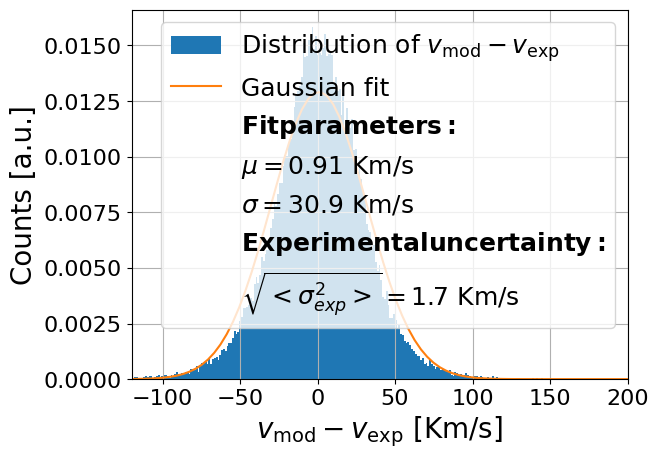

In [6]:
from scipy.stats import cauchy

VrotTry = 204.1900
uTry = 11.7086
vTry = 21.7749

VarIntrinsicTry = 30.6099

df['vModTry'] = v_mod([VrotTry, uTry, vTry, VarIntrinsicTry], df['sinl'], df['cosl'], df['D'])

df['vModTrySqrtMeanTotVar'] = np.sqrt(np.mean(df['VAR_rad_vel']) + np.mean(df['DER2_Prop_model']) * VrotTry**2 + VarIntrinsicTry**2)

plt.hist(df['vModTry']-df['radial_velocity'], bins=1000, density=True, label = r"Distribution of $v_{\text{mod}} - v_{\text{exp}}$");
plt.xlim(-120, 200)

plt.xlabel(r"$v_{\text{mod}} - v_{\text{exp}}$ [Km/s]")
plt.ylabel(r"Counts [a.u.]")

# gaussian
mu, sigma = norm.fit(df['vModTry']-df['radial_velocity'])
plt.plot(np.linspace(-200, 200, 100), norm.pdf(np.linspace(-200, 200, 100), mu, sigma), label = rf"Gaussian fit")

# cauchy lorentz
# very bad fit
# loc, scale = cauchy.fit(df['vModTry']-df['radial_velocity'])
# plt.plot(np.linspace(-200, 200, 100), cauchy.pdf(np.linspace(-200, 200, 100), loc, scale))

print("Fit Parameters: mu = {:.2f}, var = {:.2f}".format(mu, sigma**2))
print("LogPrior: {:.2f}".format(log_prior([VrotTry, uTry, vTry, VarIntrinsicTry])))
print("LogLike: {:.2f}".format(log_like([VrotTry, uTry, vTry, VarIntrinsicTry], df['radial_velocity'], df['VAR_rad_vel'], df['DER2_Prop_model'], df['sinl'], df['cosl'], df['D'])))
print("LogProb: {:.2f}".format(log_prob([VrotTry, uTry, vTry, VarIntrinsicTry], df['radial_velocity'], df['VAR_rad_vel'], df['DER2_Prop_model'], df['sinl'], df['cosl'], df['D'])))
print("Average varrad: {:.2f}".format(np.mean(df['VAR_rad_vel'])))
print("Average prop*vrot**2: {:.2f}".format(np.mean(df['DER2_Prop_model'])*VrotTry**2))

additional_labels = [
    r"$\bf{Fit parameters:}$",
    r"$\mu = ${:.2f} Km/s".format(mu),
    r"$\sigma = ${:.1f} Km/s".format(sigma),
    r"$\bf{Experimental uncertainty:}$",
    r"$\sqrt{{<\sigma^2_{{exp}}>}} = {:.1f}$ Km/s".format(
        np.sqrt(np.mean(df['VAR_rad_vel']) + np.mean(df['DER2_Prop_model']) * VrotTry**2)
    )
]

# Combine all legend entries
handles, labels = plt.gca().get_legend_handles_labels()
handles += [plt.Line2D([0], [0], color='none')] * len(additional_labels)
labels += additional_labels

plt.legend(handles, labels, loc = "upper right")

plt.grid()

## Demo of the distribution of differences (our random variable) as a function of the distance from the galactic center

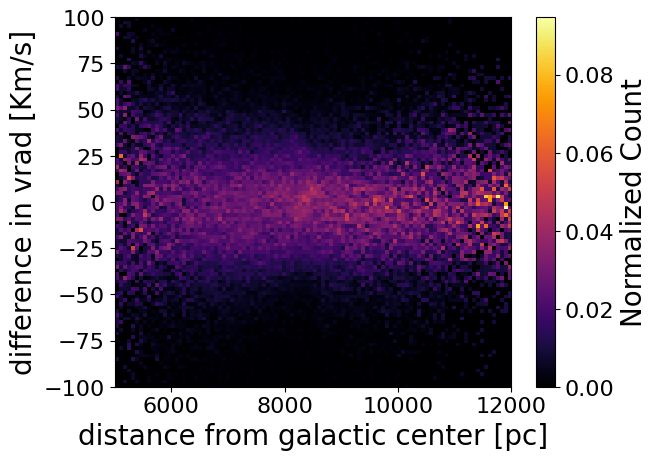

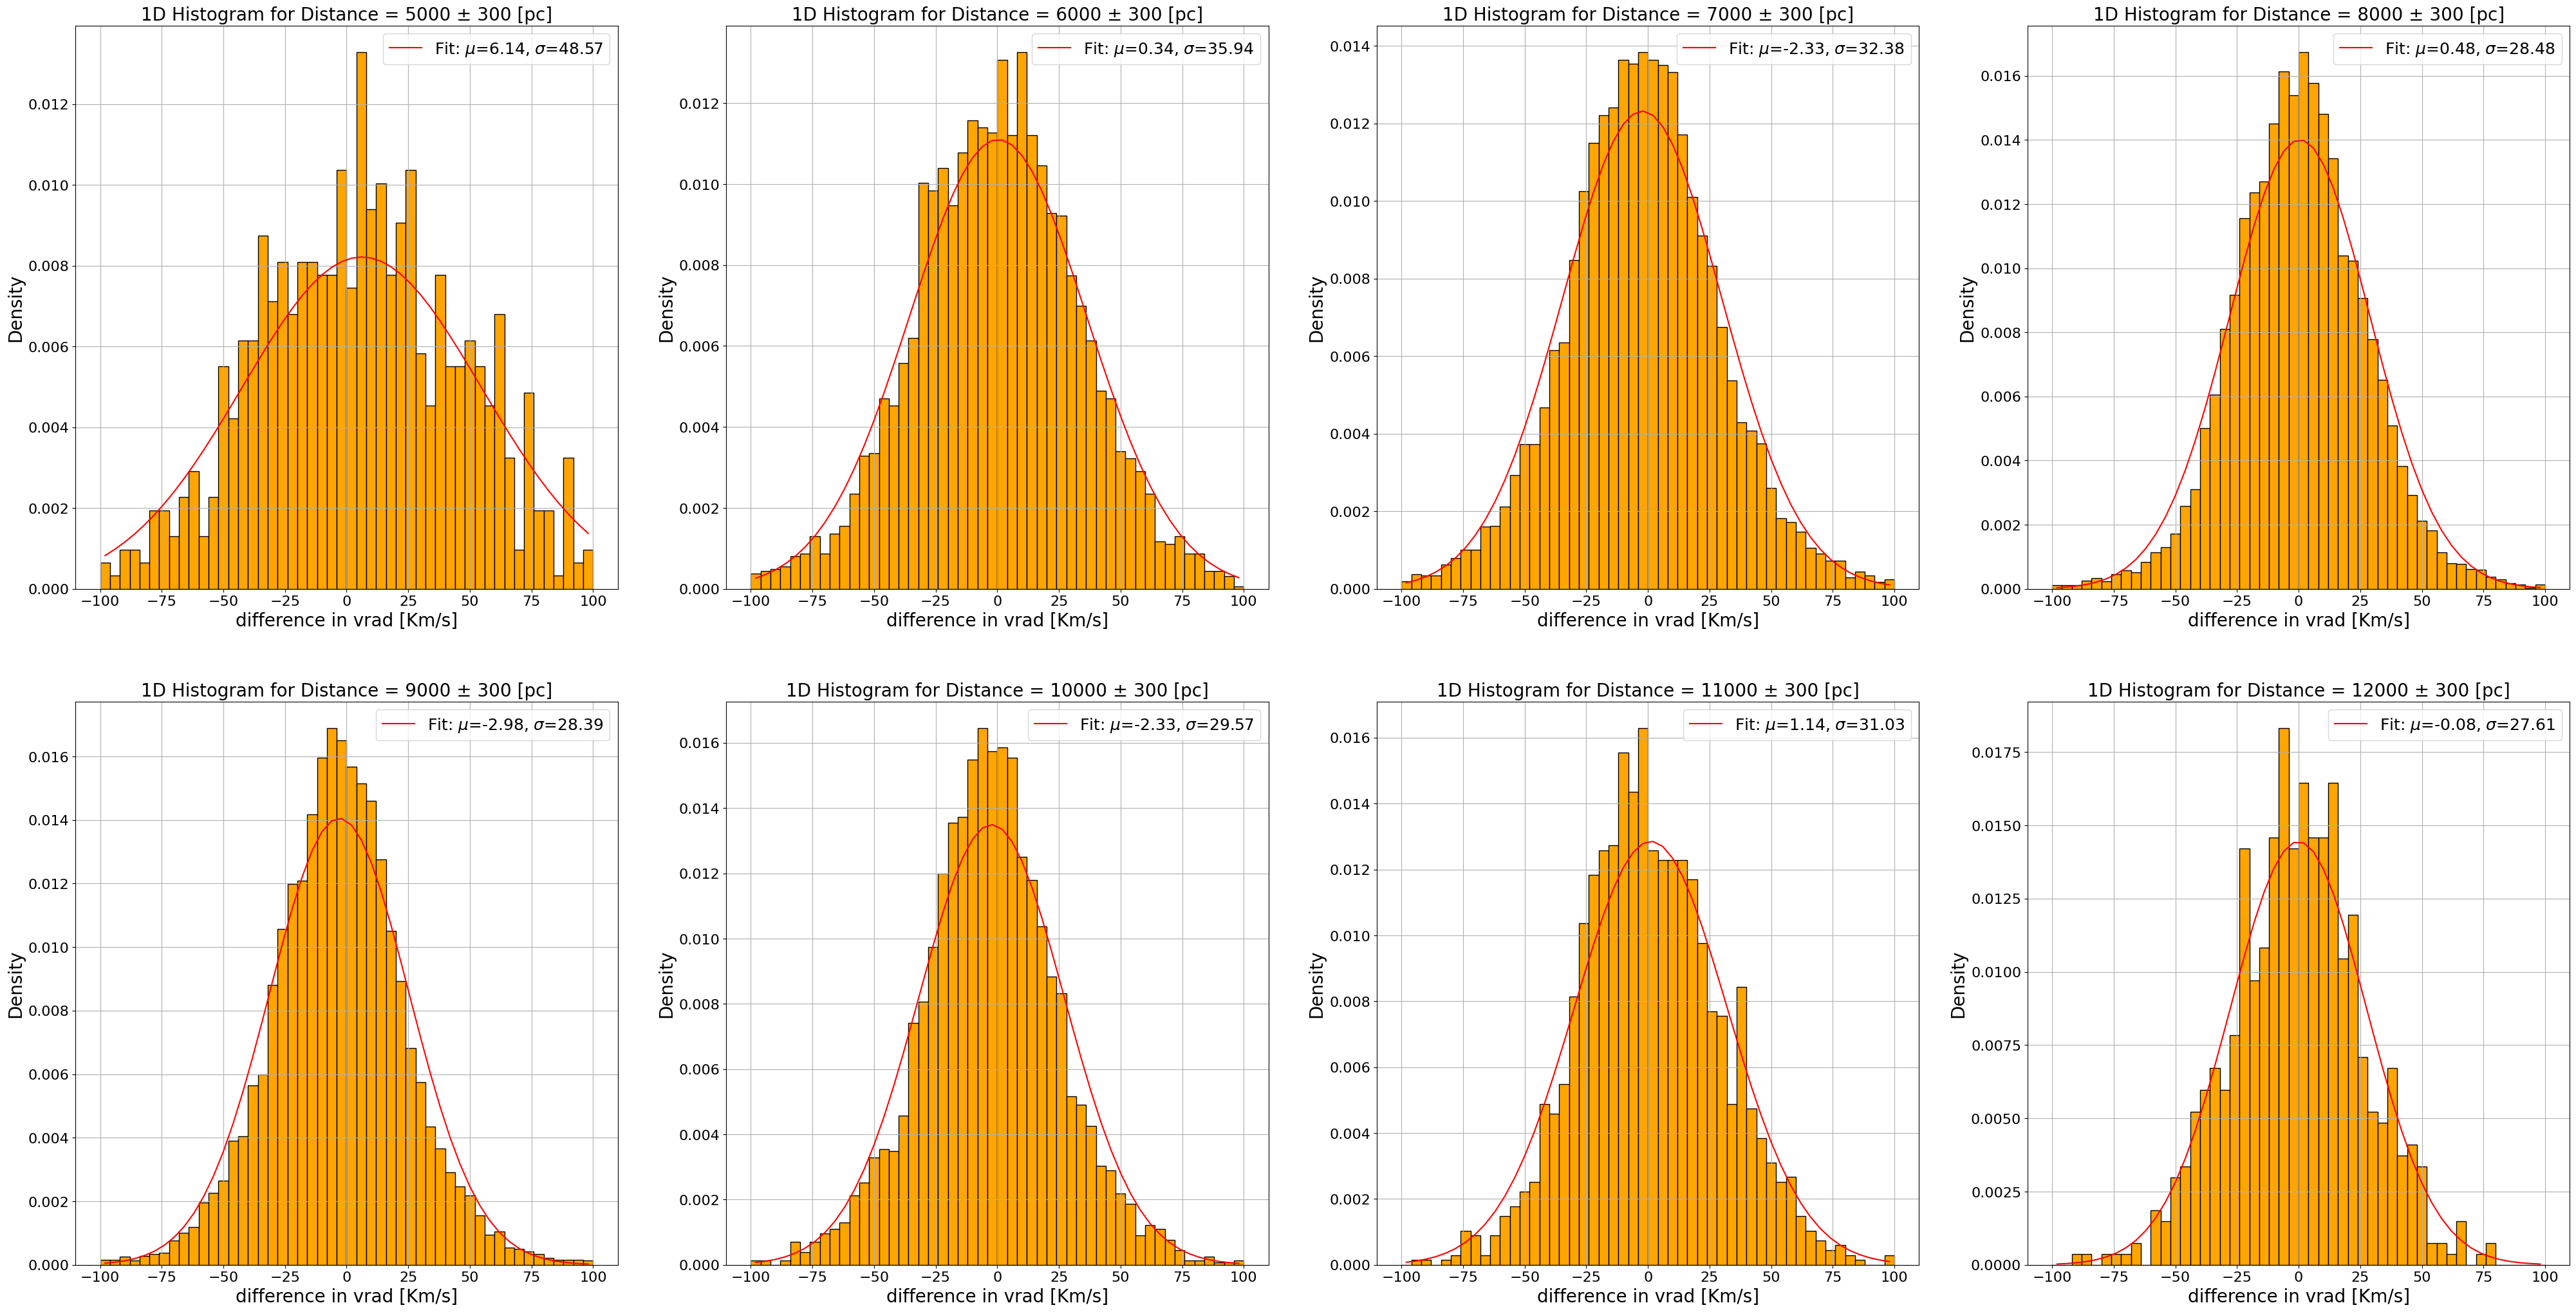

In [7]:
# plt.hist2d(df['D'], df['radial_velocity'] - df['vModTry'], bins = (100, 100), range=((5000, 12000), (-100, 100)), cmap = "inferno");
# plt.colorbar()
# plt.xlabel("distance from galactic center [pc]")
# plt.ylabel("difference in vrad [Km/s]")

# Compute the 2D histogram
hist, xedges, yedges = np.histogram2d(
    df['D'], 
    df['radial_velocity'] - df['vModTry'], 
    bins=(100, 100), 
    range=((5000, 12000), (-100, 100))
)

# Normalize each column
hist_normalized = hist / hist.sum(axis=1, keepdims=True)

# Plot the normalized histogram
plt.imshow(
    hist_normalized.T, 
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
    aspect='auto', 
    origin='lower', 
    cmap='inferno'
)
plt.colorbar(label="Normalized Count")
plt.xlabel("distance from galactic center [pc]")
plt.ylabel("difference in vrad [Km/s]")

# Filter the data for distance close to 8000 [pc]

Rows = 2
Cols = 4
fig, axs = plt.subplots(Rows, Cols, figsize = (50,25))


for i, Distance in enumerate([5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000]):
    n = i // Cols
    m = i % Cols

    distance_target = Distance
    tolerance = 300  # Define a tolerance range for filtering
    filtered_data = df[(df['D'] >= distance_target - tolerance) & (df['D'] <= distance_target + tolerance)]

    # Extract the velocity differences
    velocity_diff = filtered_data['radial_velocity'] - filtered_data['vModTry']

    # Perform Gaussian fit
    mu, sigma = norm.fit(velocity_diff)

    # Create a histogram for the velocity differences
    counts, bins, _ = axs[n, m].hist(
        velocity_diff, 
        bins=50, 
        range=(-100, 100), 
        color='orange', 
        edgecolor='black', 
        density=True  # Normalize the histogram to make it comparable to the PDF
    )

    # Plot the Gaussian fit
    bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Compute bin centers
    pdf = norm.pdf(bin_centers, mu, sigma)  # Gaussian PDF
    axs[n, m].plot(bin_centers, pdf, 'r-', label=f'Fit: $\mu$={mu:.2f}, $\sigma$={sigma:.2f}')

    # Add labels, title, and legend
    axs[n, m].set_xlabel("difference in vrad [Km/s]")
    axs[n, m].set_ylabel("Density")
    axs[n, m].set_title(f"1D Histogram for Distance = {distance_target} ± {tolerance} [pc]")
    axs[n, m].legend()
    axs[n, m].grid(True)

# Plot for presentation of data and model

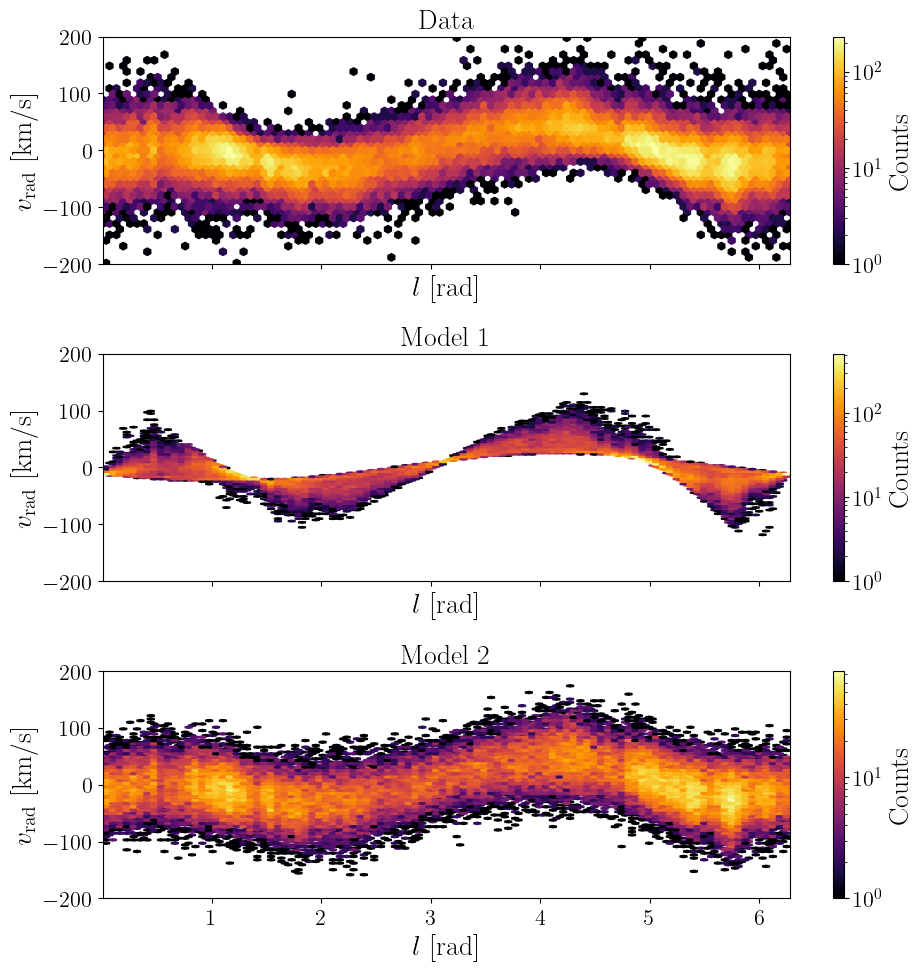

In [8]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np

# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

gridsize = 100

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True)

# First subplot: Data
hb1 = axs[0].hexbin(
    df['l'], 
    df['radial_velocity'], 
    gridsize=gridsize, 
    cmap='inferno', 
    mincnt=1, 
    norm=LogNorm()
)
axs[0].set_title(r'Data')
axs[0].set_xlabel(r'$l$ [rad]')
axs[0].set_ylabel(r'$v_{\mathrm{rad}}$ [km/s]')
fig.colorbar(hb1, ax=axs[0], label='Counts')

# Second subplot: Model 1
# values from GalaxiesSimple.ipynb

VrotTrySimple = 211.45
uTrySimple = 11.638
vTrySimple = 21.604

df['vModTrySimple'] = v_mod([VrotTrySimple, uTrySimple, vTrySimple, 0], df['sinl'], df['cosl'], df['D'])


hb2 = axs[1].hexbin(
    df['l'], 
    df['vModTrySimple'], 
    gridsize=gridsize, 
    cmap='inferno', 
    mincnt=1, 
    norm=LogNorm()
)
axs[1].set_title(r'Model 1')
axs[1].set_xlabel(r'$l$ [rad]')
axs[1].set_ylabel(r'$v_{\mathrm{rad}}$ [km/s]')
fig.colorbar(hb2, ax=axs[1], label='Counts')

# Third subplot: Model 2
df['vModTryStatModel'] = df['vModTry'] + np.random.normal(0, VarIntrinsicTry, size=df['vModTry'].size)
hb3 = axs[2].hexbin(
    df['l'], 
    df['vModTryStatModel'], 
    gridsize=gridsize, 
    cmap='inferno', 
    mincnt=1, 
    norm=LogNorm()
)
axs[2].set_title(r'Model 2')
axs[2].set_xlabel(r'$l$ [rad]')
axs[2].set_ylabel(r'$v_{\mathrm{rad}}$ [km/s]')
fig.colorbar(hb3, ax=axs[2], label='Counts')

# Set the same limits for all subplots
for ax in axs:
    ax.set_xlim(df['l'].min(), df['l'].max())
    ax.set_ylim(-200, 200)

plt.tight_layout()

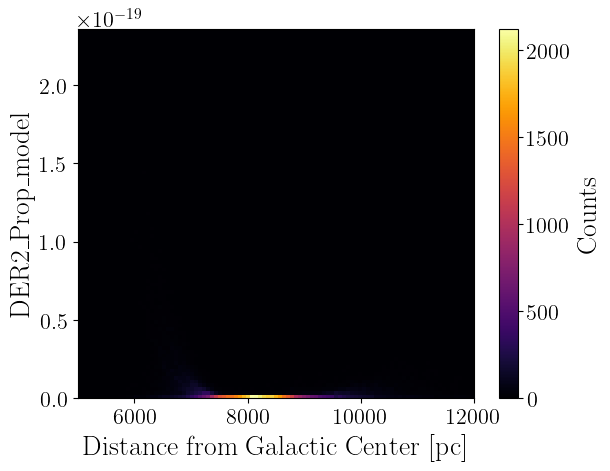

In [9]:
# check how der2propmodel varies with the distance from galactic center
# Define axis limits
x_min, x_max = 5000, 12000
y_min, y_max = 0, np.mean(df["DER2_Prop_model"])*2

# Set the number of bins for each axis
x_bins = 100  # Number of bins for the x-axis
y_bins = 100  # Number of bins for the y-axis

# Create the 2D histogram with specified bins and axis limits
plt.hist2d(
    df["D"], 
    df["DER2_Prop_model"], 
    bins=(np.linspace(x_min, x_max, x_bins), np.linspace(y_min, y_max, y_bins)), 
    cmap="inferno"
)

# Set axis limits
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))

# Add labels and colorbar
plt.xlabel("Distance from Galactic Center [pc]")
plt.ylabel("DER2_Prop_model")
plt.colorbar(label="Counts")
plt.show()

## Walkers to sample space parameter

In [ ]:
import emcee

ndim = 4  
nwalkers = 96
nsteps = 10000 
burnin = 250

# Valori iniziali casuali per i walker
p0 = np.random.randn(nwalkers, ndim) 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(df['radial_velocity'], df['VAR_rad_vel'], df['DER2_Prop_model'], df['sinl'], df['cosl'], df['D']))

sampler.run_mcmc(p0, nsteps, progress=True)

flat_samples = sampler.get_chain(discard=burnin, thin=10, flat=True)

#save to file
np.save("FlatSamplesFull", flat_samples)

print("Forma dei campioni:", flat_samples.shape)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/gabri/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 17%|█▋        | 1697/10000 [11:33<50:39,  2.73it/s]  

plot the walkers

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burnin)
labels = [r"$V_{\mathrm{rot}} \mathrm{ [Km/s]}$", r"$U_{\odot} \mathrm{ [Km/s]}$", r"$V_{\odot} \mathrm{ [Km/s]}$", r"$\sigma \mathrm{ [Km/s]}$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

Text(0.5, 0, 'step number')

Error in callback <function _draw_all_if_interactive at 0x7fcf32f8a3b0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'$V_{\\\\text{rot}} \\\\text{ [Km/s]}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp2gts65xu 523a5901e8ac130e8f82a150d3518474.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./523a5901e8ac130e8f82a150d3518474.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 523a5901e8ac130e8f82a150d3518474.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.29 {\rmfamily $V_{\text
                         {rot}} \text{ [Km/s]}$}%
No pages of output.
Transcript written on tmp2gts65xu/523a5901e8ac130e8f82a150d3518474.log.




RuntimeError: latex was not able to process the following string:
b'$V_{\\\\text{rot}} \\\\text{ [Km/s]}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp2bnjq_60 523a5901e8ac130e8f82a150d3518474.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./523a5901e8ac130e8f82a150d3518474.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 523a5901e8ac130e8f82a150d3518474.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.29 {\rmfamily $V_{\text
                         {rot}} \text{ [Km/s]}$}%
No pages of output.
Transcript written on tmp2bnjq_60/523a5901e8ac130e8f82a150d3518474.log.




<Figure size 1000x700 with 4 Axes>

plot contour

In [ ]:
import corner

# Assuming `samples` is an (N, 4) array where N is the number of samples
FlatSamples = np.load("FlatSamplesFull") # load from file
best_values = np.median(FlatSamples, axis=0)  # Median for each parameter
credible_intervals = np.percentile(FlatSamples, [2.5, 97.5], axis=0)  # 95% credible interval

# Display results
for i, (median, lower, upper) in enumerate(zip(best_values, credible_intervals[0], credible_intervals[1])):
    print(f"Parameter {i+1}: Median = {median:.4f}, 95% CI = [{lower:.4f}, {upper:.4f}]")

print(FlatSamples.shape)
fig = corner.corner(FlatSamples, labels=labels, truths = best_values, truth_color  ="red", label_kwargs={"fontsize": 14}, quantiles=[0.025, 0.975])

fig.savefig("PosteriorFull.png", dpi=1000, bbox_inches="tight")